In [2]:
import numpy as np
#import rasterio
import matplotlib.pyplot as plt
%matplotlib inline


# the following names should be changed for each use
# specify the location and name of the DEM
fdir = "D:\\crs\\proj\\2015_Sandwich\\2017-09-18_U039_SandwichTNB\\products\\"
fname = ("2017-09-18_U039_SandwichTNB_v3_DEM_10cm.tif")
# specify the name of the transect file (assumed to be in same directory)
tfname = '2017-09-18_trans.txt'
# text for plot titles
ttext = "Sandwich 18-Sep-2017"


In [10]:
# read in the transect points with dune grass elevations
dgfname = "2017-10-06_Sandwich_Dune_Grass_Elevations.txt"
column_names = ['id','n','e','elev','hgt']
import pandas as pd
df=pd.read_csv(fdir+dgfname,header = None, names = column_names)
print(df)
print("Read: ",len(df.index),' lines.')

      id             n            e    elev  hgt
0    100  4.624914e+06  376799.2019  5.8398   50
1    101  4.624911e+06  376803.2719  5.8027   35
2    102  4.624908e+06  376807.7269  5.7686   25
3    103  4.624904e+06  376813.0444  5.6955   45
4    104  4.624901e+06  376818.7094  5.4523   50
5    105  4.624897e+06  376824.0096  5.0842   45
6    106  4.624894e+06  376829.9251  4.6130   55
7    107  4.624891e+06  376835.0566  4.3699   55
8    108  4.624887e+06  376840.0106  3.9977   55
9    109  4.624885e+06  376845.2441  3.7316   55
10   110  4.624889e+06  376845.7671  3.6126   40
11   111  4.624894e+06  376840.0415  4.0117   45
12   112  4.624898e+06  376835.4786  4.5569   50
13   113  4.624902e+06  376830.0737  4.9120   50
14   114  4.624907e+06  376824.6487  5.0691   60
15   115  4.624912e+06  376819.4051  5.2083   50
16   116  4.624917e+06  376813.8428  5.4324   50
17   117  4.624922e+06  376808.6150  5.3216   55
18   118  4.624906e+06  376806.1567  5.5006   40
19   119  4.624910e+

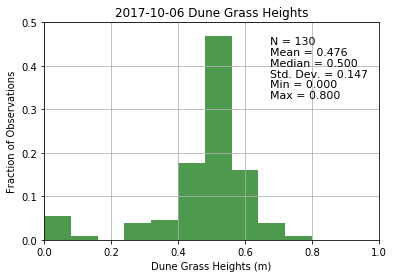

In [45]:
## Histogram of the data
x = df['hgt'].as_matrix()
x = x/100. # convert to meters
xN = len(x)
xMAD = np.mean(np.abs(x))
xmean = x.mean()
xmedian = df['hgt'].median()/100.
xstd = x.std()
xmin = x.min()
xmax = x.max()
xRMS = np.sqrt(np.mean(x**2))

fig = plt.figure()
# next line must be combined with normed=False to get fractional distribution correct
weights = np.ones_like(x)/float(len(x))
n, bins, patches = plt.hist(x, bins=10, weights=weights, normed=False, facecolor=(.3,.6,.3), alpha=1)
xaxmax = 1
xaxmin = 0
yaxmin = 0.
yaxmax = .5

plt.xlabel('Dune Grass Heights (m)')
plt.ylabel('Fraction of Observations')
plt.title('2017-10-06 Dune Grass Heights')
plt.axis([xaxmin, xaxmax, yaxmin, yaxmax])
plt.grid(True)
plt.text(.675*(xaxmax-xaxmin)+xaxmin,.9*(yaxmax-yaxmin)+yaxmin,'N = {}'.format(xN), fontsize=11)
plt.text(.675*(xaxmax-xaxmin)+xaxmin,.85*(yaxmax-yaxmin)+yaxmin,'Mean = {:.3f}'.format(xmean), fontsize=11)
plt.text(.675*(xaxmax-xaxmin)+xaxmin,.8*(yaxmax-yaxmin)+yaxmin,'Median = {:.3f}'.format(xmedian), fontsize=11)
plt.text(.675*(xaxmax-xaxmin)+xaxmin,.75*(yaxmax-yaxmin)+yaxmin,'Std. Dev. = {:.3f}'.format(xstd), fontsize=11)
plt.text(.675*(xaxmax-xaxmin)+xaxmin,.7 *(yaxmax-yaxmin)+yaxmin,'Min = {:.3f}'.format(xmin), fontsize=11)
plt.text(.675*(xaxmax-xaxmin)+xaxmin,.65*(yaxmax-yaxmin)+yaxmin,'Max = {:.3f}'.format(xmax), fontsize=11)
plt.show()

fig_name = fdir+"hist_Dune_Grass_Heights.png"
fig.savefig(fig_name)

In [26]:
# read DEM channel 1
with rasterio.open(fdir+fname) as dem:
    z = dem.read(1)
    
print(np.shape(z))

(13830, 17170)


In [27]:
# bilinear interpolation
def bilint(z,en):
    """
    https://en.wikipedia.org/wiki/Bilinear_interpolation for a unit square
    """
    r = en[1]
    c = en[0]
    ir = np.int(r)
    ic = np.int(c)
    rx = r-ir
    cy = c-ic
    #print(r,ir,rx,'  ',c,ic,cy)
    #print(z[ir,ic],z[ir+1,ic])
    #print(z[ir+1,ic],z[ir+1,ic+1])
    zi = z[ir,ic]*(1.-cy)*(1.-rx)+z[ir+1,ic]*cy*(1.-rx)+z[ir,ic+1]*(1.-cy)*rx+z[ir+1,ic+1]*rx*cy
    return zi

In [28]:
# arrays for DEM and differences calcs
# using only bilinear interpolation, not corners
zdem = np.NaN*np.ones(len(df.index))
zdem_minus_meas = np.NaN*np.ones(len(df.index))

for index, row in df.iterrows():
    # print(row["n"], row["e"])
    en = ~dem.transform*(row["e"],row["n"])
    # print( index, en )

    # this one does bilinear interpolation
    try:
        zdem[index]=bilint(z,en)
    except:
        print("interpolation problem")
    
    # No data values for DEM are -32767
    if(zdem[index]<-32766.):
        zdem[index]=np.NaN
    
    zdem_minus_meas[index] = zdem[index]-row["elev"]
    #print( zdem[index], zdi[index], row["elev"], zdem_minus_meas[index]  )

In [29]:
# add columns to the dataframe
#df.assign(DEM2=pd.Series(zdem,index=df.index))
df['DEM int']=pd.Series(zdem,index=df.index)
df['DEM_minus_trans']=pd.Series(zdem_minus_meas,index=df.index)


In [30]:
df.to_csv('2017-09-18_Sandwich_Dune_Grass.csv',na_rep='-32767',sep=',',float_format='% 12.4f')
df

,id,n,e,elev,hgt,DEM int,DEM_minus_trans
0,100,4.624914e+06,376799.2019,5.8398,50,6.136710,0.296910
1,101,4.624911e+06,376803.2719,5.8027,35,5.886315,0.083615
2,102,4.624908e+06,376807.7269,5.7686,25,5.876419,0.107819
3,103,4.624904e+06,376813.0444,5.6955,45,5.699188,0.003688
4,104,4.624901e+06,376818.7094,5.4523,50,5.599974,0.147674
5,105,4.624897e+06,376824.0096,5.0842,45,5.218102,0.133902
6,106,4.624894e+06,376829.9251,4.6130,55,4.886057,0.273057
7,107,4.624891e+06,376835.0566,4.3699,55,4.654790,0.284890
8,108,4.624887e+06,376840.0106,3.9977,55,4.122677,0.124977
9,109,4.624885e+06,376845.2441,3.7316,55,3.850062,0.118462


In [31]:
df['DEM_minus_trans'].describe()

count    130.000000
mean       0.208499
std        0.161360
min       -0.083621
25%        0.064719
50%        0.213647
75%        0.326356
max        0.616196
Name: DEM_minus_trans, dtype: float64

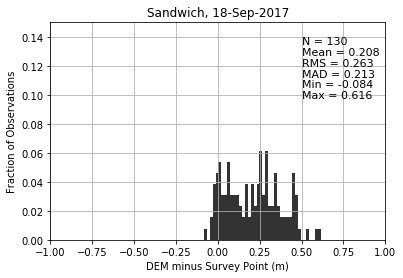

In [33]:
## Histogram of the data
x = df['DEM_minus_trans'].as_matrix()
x = x[~np.isnan(x)]
x = x[np.abs(x)<5.]

xN = len(x)
xMAD = np.mean(np.abs(x))
xmean = x.mean()
xmin = x.min()
xmax = x.max()
xRMS = np.sqrt(np.mean(x**2))

fig = plt.figure()
# next line must be combined with normed=False to get fractional distribution correct
weights = np.ones_like(x)/float(len(x))
n, bins, patches = plt.hist(x, bins=40, weights=weights, normed=False, facecolor=(.2,.2,.2), alpha=1)
xaxmax = 1
xaxmin = -1
yaxmin = 0.
yaxmax = .15

plt.xlabel('DEM minus Survey Point (m)')
plt.ylabel('Fraction of Observations')
plt.title(ttext)
plt.axis([xaxmin, xaxmax, yaxmin, yaxmax])
plt.grid(True)
plt.text(.75*(xaxmax-xaxmin)+xaxmin,.9*(yaxmax-yaxmin)+yaxmin,'N = {}'.format(xN), fontsize=11)
plt.text(.75*(xaxmax-xaxmin)+xaxmin,.85*(yaxmax-yaxmin)+yaxmin,'Mean = {:.3f}'.format(xmean), fontsize=11)
plt.text(.75*(xaxmax-xaxmin)+xaxmin,.8*(yaxmax-yaxmin)+yaxmin,'RMS = {:.3f}'.format(xRMS), fontsize=11)
plt.text(.75*(xaxmax-xaxmin)+xaxmin,.75*(yaxmax-yaxmin)+yaxmin,'MAD = {:.3f}'.format(xMAD), fontsize=11)
plt.text(.75*(xaxmax-xaxmin)+xaxmin,.7 *(yaxmax-yaxmin)+yaxmin,'Min = {:.3f}'.format(xmin), fontsize=11)
plt.text(.75*(xaxmax-xaxmin)+xaxmin,.65*(yaxmax-yaxmin)+yaxmin,'Max = {:.3f}'.format(xmax), fontsize=11)
plt.show()

fig_name = fdir+"hist_DEM_minus_transect_at_dune_grass_transects.png"
fig.savefig(fig_name)

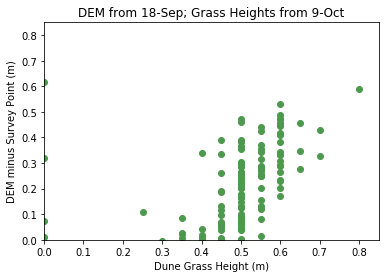

In [44]:
## Histogram of the data
diff = df['DEM_minus_trans'].as_matrix()
dgh = df['hgt'].as_matrix()/100.

xaxmax = .85
xaxmin = 0.
yaxmin = 0.
yaxmax = .85

fig = plt.figure()
plt.plot(dgh,diff,color=(.3,.6,.3),marker='o',linestyle='none')
plt.xlabel('Dune Grass Height (m)')
plt.ylabel('DEM minus Survey Point (m)')
plt.title('DEM from 18-Sep; Grass Heights from 9-Oct')
plt.axis([xaxmin, xaxmax, yaxmin, yaxmax])
fig_name = fdir+"scatter_DEM_minus_transect_at_dune_grass_transects.png"
fig.savefig(fig_name)

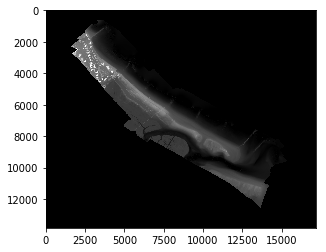

In [12]:
plt.plot(figsize=(12,6));plt.imshow(z[::],cmap=plt.cm.gray,vmin=-2,vmax=13)